Statistical estimation and error bars
=====================================

Data visualization sometimes involves a step of aggregation or estimation, where multiple data points are reduced to a summary statistic such as the mean or median. When showing a summary statistic, it is usually appropriate to add *error bars*, which provide a visual cue about how well the summary represents the underlying data points.

Several seaborn functions will automatically calculate both summary statistics and the error bars when given a full dataset. This chapter explains how you can control what the error bars show and why you might choose each of the options that seaborn affords.

The error bars around an estimate of central tendency can show one of two general things: either the range of uncertainty about the estimate or the spread of the underlying data around it. These measures are related: given the same sample size, estimates will be more uncertain when data has a broader spread. But uncertainty will decrease as sample sizes grow, whereas spread will not.

In seaborn, there are two approaches for constructing each kind of error bar. One approach is parametric, using a formula that relies on assumptions about the shape of the distribution. The other approach is nonparametric, using only the data that you provide.

Your choice is made with the `errorbar` parameter, which exists for each function that does estimation as part of plotting. This parameter accepts the name of the method to use and, optionally, a parameter that controls the size of the interval. The choices can be defined in a 2D taxonomy that depends on what is shown and how it is constructed:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="darkgrid")

In [ ]:
np.random.seed(sum(map(ord, "errorbars"))) # For reproducibility, ord is the Unicode code point of a character, errorbars is just a string

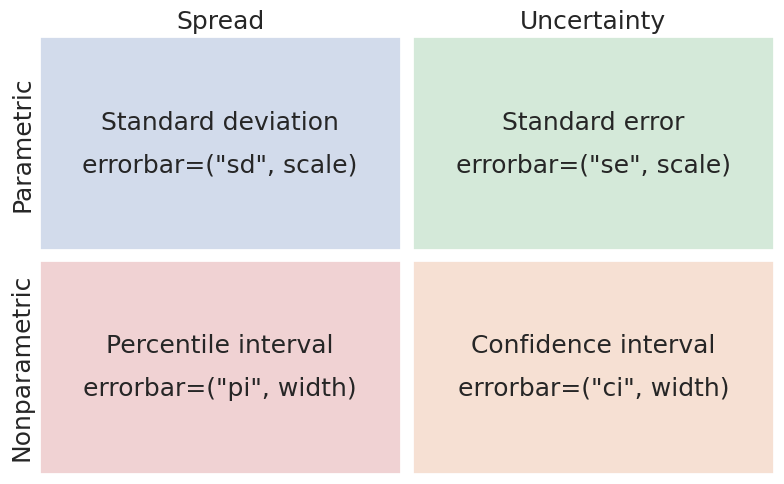

In [2]:

%run errorbarplot.py


You will note that the size parameter is defined differently for the parametric and nonparametric approaches. For parametric error bars, it is a scalar factor that is multiplied by the statistic defining the error (standard error or standard deviation). For nonparametric error bars, it is a percentile width. This is explained further for each specific approach below.

To compare the different parameterizations, we'll use the following helper function:

In [13]:
#make a function to plot error bars
def plot_errorbars(arg, **kws): #arg is the error bar type, kws are other keyword arguments, the ** means it can take any number of keyword arguments
    np.random.seed(sum(map(ord, "error_bars"))) # For reproducibility
    x = np.random.normal(0, 1, 100) #generate some random data centered around 0 with standard deviation of 1, 100 points
    f, axs = plt.subplots(2, figsize=(4, 4), #initialize subplots with 2 rows, figure size 7x2
                          sharex=True, #share x axis
                          layout="tight") #tight layout to minimize overlaps
    sns.pointplot(x=x, #plot point plot with error bars, x is the random data made above
                  errorbar=arg, #error bar type passed as argument in the function
                  **kws, #other keyword arguments passed in the function
                  capsize=.3, #size of the error bar caps, we could put this in the function call too
                  ax=axs[0] #plot on the first axis using index notation
                  )
    
    sns.stripplot(x=x, #plot strip plot with error bars, x is the random data made above,
                  jitter=.3,#amount of jitter to add to the points
                  ax=axs[1] #plot on the second axis using index notation
                  )


## Measures of data spread
-----------------------

Error bars that represent data spread present a compact display of the distribution, using three numbers where `boxplot` would use 5 or more and `violinplot` would use a complicated algorithm.

### Standard deviation error bars

Standard deviation error bars are the simplest to explain, because the standard deviation is a familiar statistic. It is the average distance from each data point to the sample mean. By default, `errorbar="sd"` will draw error bars at +/- 1 sd around the estimate, but the range can be increased by passing a scaling size parameter. Note that, assuming normally-distributed data, ~68% of the data will lie within one standard deviation, ~95% will lie within two, and ~99.7% will lie within three:

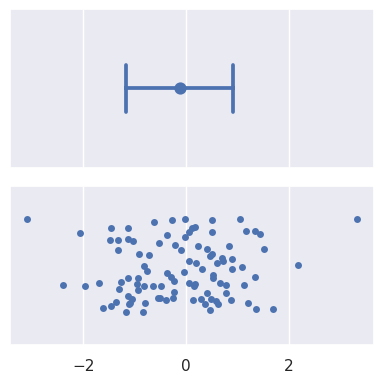

In [14]:
plot_errorbars("sd") #call the function to plot standard deviation error bars, the arg is "sd" or standard deviation

### Percentile interval error bars

Percentile intervals also represent the range where some amount of the data fall, but they do so by 
computing those percentiles directly from your sample. By default, `errorbar="pi"` will show a 95% interval, ranging from the 2.5 to the 97.5 percentiles. You can choose a different range by passing a size parameter, e.g., to show the inter-quartile range:

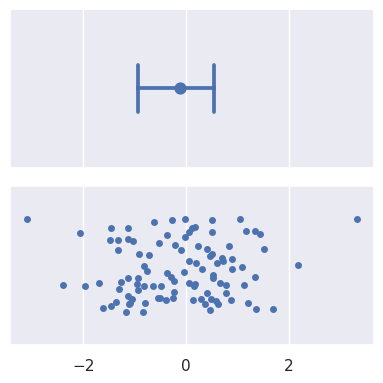

In [15]:
plot_errorbars(("pi", 50)) #call the function to plot 50% prediction interval error bars, the arg is a tuple ("pi", 50)

The standard deviation error bars will always be symmetrical around the estimate. This can be a problem when the data are skewed, especially if there are natural bounds (e.g., if the data represent a quantity that can only be positive). In some cases, standard deviation error bars may extend to "impossible" values. The nonparametric approach does not have this problem, because it can account for asymmetrical spread and will never extend beyond the range of the data.

## Measures of estimate uncertainty
--------------------------------

If your data are a random sample from a larger population, then the mean (or other estimate) will be an imperfect measure of the true population average. Error bars that show estimate uncertainty try to represent the range of likely values for the true parameter.

### Standard error bars

The standard error statistic is related to the standard deviation: in fact it is just the standard deviation divided by the square root of the sample size. The default, with `errorbar="se"`, draws an interval +/-1 standard error from the mean:

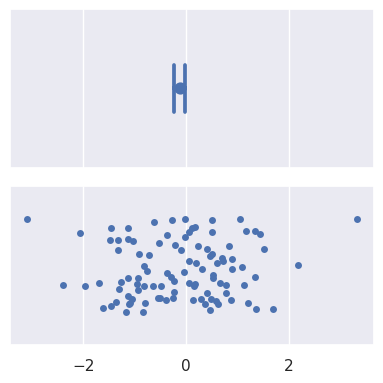

In [16]:
plot_errorbars("se")

## Confidence interval error bars

The nonparametric approach to representing uncertainty uses *bootstrapping*: a procedure where the dataset is randomly resampled with replacement a number of times, and the estimate is recalculated from each resample. This procedure creates a distribution of statistics approximating the distribution of values that you could have gotten for your estimate if you had a different sample.

The confidence interval is constructed by taking a percentile interval of the *bootstrap distribution*. By default `errorbar="ci"` draws a 95% confidence interval:

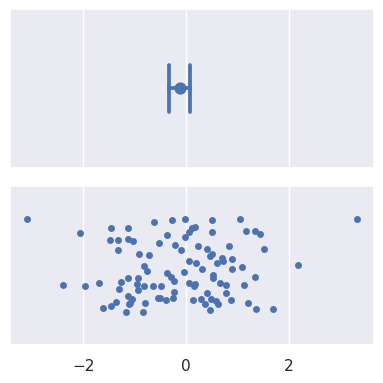

In [17]:
plot_errorbars("ci")

The seaborn terminology is somewhat specific, because a confidence interval in statistics can be parametric or nonparametric. To draw a parametric confidence interval, you scale the standard error, using a formula similar to the one mentioned above. For example, an approximate 95% confidence interval can be constructed by taking the mean +/- two standard errors:

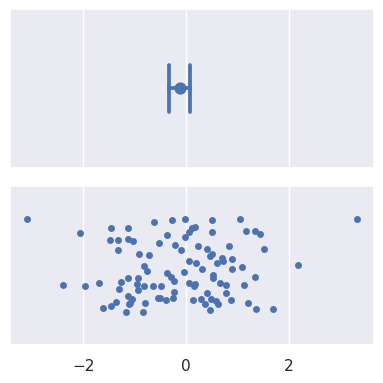

In [18]:
plot_errorbars(("se", 2))

The nonparametric bootstrap has advantages similar to those of the percentile interval: it will naturally adapt to skewed and bounded data in a way that a standard error interval cannot. It is also more general. While the standard error formula is specific to the mean, error bars can be computed using the bootstrap for any estimator:

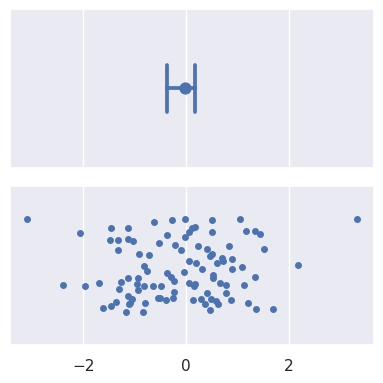

In [19]:
plot_errorbars("ci", estimator="median")

Bootstrapping involves randomness, and the error bars will appear slightly different each time you run the code that creates them. A few parameters control this. One sets the number of iterations (`n_boot`): with more iterations, the resulting intervals will be more stable. The other sets the `seed` for the random number generator, which will ensure identical results:

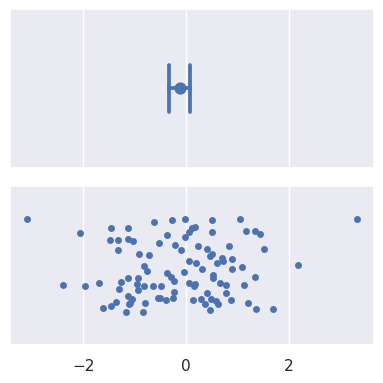

In [20]:
plot_errorbars("ci", n_boot=5000, seed=10)

Because of its iterative process, bootstrap intervals can be expensive to compute, especially for large datasets. But because uncertainty decreases with sample size, it may be more informative in that case to use an error bar that represents data spread.

### Custom error bars

If these recipes are not sufficient, it is also possible to pass a generic function to the `errorbar` parameter. This function should take a vector and produce a pair of values representing the minimum and maximum points of the interval:

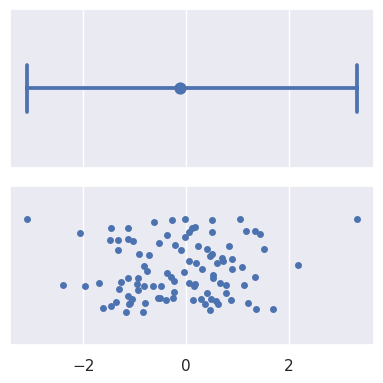

In [21]:
plot_errorbars(lambda x: (x.min(), x.max()))

(In practice, you could show the full range of the data with `errorbar=("pi", 100)` rather than the custom function shown above).

Note that seaborn functions cannot currently draw error bars from values that have been calculated externally, although matplotlib functions can be used to add such error bars to seaborn plots.

## Error bars on regression fits
-----------------------------

The preceding discussion has focused on error bars shown around parameter estimates for aggregate data. Error bars also arise in seaborn when estimating regression models to visualize relationships. Here, the error bars will be represented by a "band" around the regression line:

<Axes: >

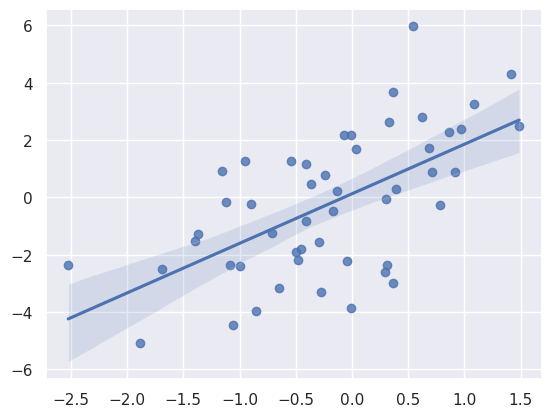

In [22]:
x = np.random.normal(0, 1, 50)
y = x * 2 + np.random.normal(0, 2, size=x.size)
sns.regplot(x=x, y=y)

Currently, the error bars on a regression estimate are less flexible, only showing a confidence interval with a size set through `ci=`. This may change in the future.

### Are error bars enough?
----------------------

You should always ask yourself whether it's best to use a plot that displays only a summary statistic and error bar. In many cases, it isn't.

If you are interested in questions about summaries (such as whether the mean value differs between groups or increases over time), aggregation reduces the complexity of the plot and makes those inferences easier. But in doing so, it obscures valuable information about the underlying data points, such as the shape of the distributions and the presence of outliers.

When analyzing your own data, don't be satisfied with summary statistics. Always look at the underlying distributions too. Sometimes, it can be helpful to combine both perspectives into the same figure. Many seaborn functions can help with this task, especially those discussed in the `categorical tutorial`.

Now we will explore [Regression Fits](./Mod9-regression.ipynb)